In [127]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt


# define continuous dynamics 
A = np.array([[0., 0., 1., 0.],
              [0., 0., 0., 1.],
              [0., 0., 0., 0.],
              [0., 0., 0., 0.]])
B = np.array([[0., 0.],
              [0., 0.],
              [1., 0.],
              [0., 1.]])
Q = np.diag([1.0, 1.0, 0.1, 0.1])
R = np.diag([0.1, 0.1])
state_dim, ctrl_dim = 4, 2

# Solve continuous lqr
S = np.array(scipy.linalg.solve_continuous_are(A, B, Q, R))
K = np.array(scipy.linalg.inv(R)@B.T@S)
print(K.shape)

# TODO: optimize this using lifted dynamics, don't loop through
def rollout(x0, xg, N, dt, dist_tol=None):
    xs = np.zeros((N+1, state_dim))
    xs[0, :] = x0
    
    x = np.copy(x0)
    for i in range(1, N+1):
        u = (-K @ (x-xg))
        xdot = A @ x + B @ u
        x += xdot * dt
        xs[i, :] = x
        
        if dist_tol is not None:
            dist = np.linalg.norm(x - xg)
            if dist < dist_tol:
                return xs[:i+1], True
        
    return xs, False


N = 10
dt = 0.3
x0 = np.array([0.0, 0.0, 0.0, 0.0])
xg = np.array([5.0, 3.0, 0.0, 0.0])

xs, _ = rollout(x0, xg, N, dt)




(2, 4)


In [11]:
xs

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  4.74341649,  2.84604989],
       [ 1.42302495,  0.85381497,  5.63557026,  3.38134216],
       [ 3.11369603,  1.86821762,  4.4533688 ,  2.67202128],
       [ 4.44970667,  2.669824  ,  2.62710594,  1.57626357],
       [ 5.23783845,  3.14270307,  1.01616683,  0.6097001 ],
       [ 5.5426885 ,  3.3256131 , -0.03451014, -0.02070608],
       [ 5.53233546,  3.31940127, -0.52133027, -0.31279816],
       [ 5.37593638,  3.22556183, -0.60307087, -0.36184252],
       [ 5.19501511,  3.11700907, -0.47007166, -0.28204299],
       [ 5.05399362,  3.03239617, -0.27341985, -0.16405191]])

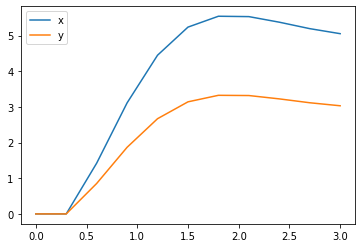

In [12]:
ts = np.arange(0, N*dt + dt, step=dt)
plt.plot(ts, xs[:, 0], label="x")
plt.plot(ts, xs[:, 1], label="y")
plt.legend()
plt.show()

In [ ]:
# while not reached goal:
#     if not plan_valid:
#         replan()
        
#     execute next_step
     

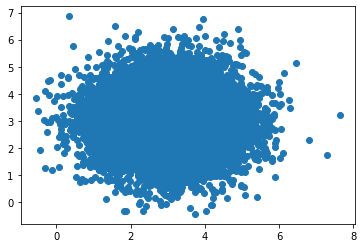

In [13]:
mean = np.array([3,3])
cov = np.array([
    [1, 0],
    [0, 1]
])
points = np.random.multivariate_normal(mean, cov, 10000)
plt.scatter(points[:, 0], points[:, 1])
plt.show()

In [14]:
vec = xg[:2] - x0[:2]
mag_vec = np.linalg.norm(vec)
vec /= mag_vec

In [15]:
np.array([vec[1], -vec[0]]).shape

(2,)

In [16]:
vec.T @ np.array([vec[1], -vec[0]])

0.0

In [30]:
# https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/
# Biasing sampling along vector from start to goal
def sample_along_vec(x0, xg, N, D):
    vec = xg[:D] - x0[:D]
    vec /= np.linalg.norm(vec)

    mag_vec = 0.2 * np.linalg.norm(xg[:D] - x0[:D])
    mag_orth = 0.3 * mag_vec
    if D == 2:
        orth_vec = np.array([vec[1], -vec[0]])
        L = np.diag([mag_vec, mag_orth])
        V = np.hstack([
            vec[:, np.newaxis], orth_vec[:, np.newaxis]
        ])
    elif D == 3:
        # https://math.stackexchange.com/questions/137362/how-to-find-perpendicular-vector-to-another-vector
        # (0,c,−b),(−c,0,a) and (−b,a,0) for any nonzero vec <a,b,c>
        a, b, c = vec.flatten()
        orth_vec1 = np.array([0, c, -b])
        orth_vec2 = np.array([-c, 0, a])
        L = np.diag([mag_vec, mag_orth, mag_orth])
        V = np.hstack([
            vec[:, np.newaxis], orth_vec1[:, np.newaxis], orth_vec2[:, np.newaxis]
        ])
    else:
        raise(NotImplementedError("Only supports 2D or 3D"))
        
    mu = ((xg[:D] + x0[:D]) / 2).flatten()
    cov = V @ L @ V.T
    points = np.random.multivariate_normal(mu, cov, N)
    return points

[5. 3.]


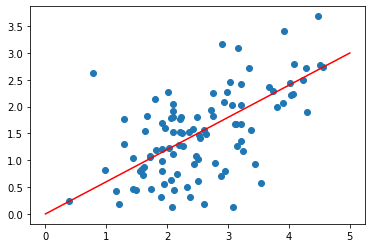

In [24]:
points = sample_along_vec(x0, xg, N=100, D=2)
plt.scatter(points[:, 0], points[:, 1])
plt.plot([x0[0], xg[0]], [x0[1], xg[1]], "r")
plt.show()

[2. 5. 3.]


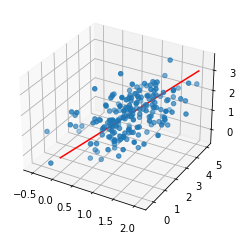

In [27]:

p1 = np.array([0, 0, 0.])
p2 = np.array([2, 5, 3.])
points = sample_along_vec(p1, p2, N=200, D=3)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.plot(xs=[p1[0], p2[0]], ys=[p1[1], p2[1]], zs=[p1[2], p2[2]], color="r")
plt.show()

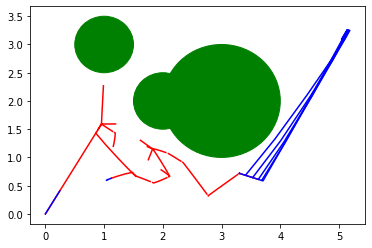

True


In [113]:
# TODO: make obstacle reachable sets polygons and use point-in-polygon to check collision
# if self is polygon, just find nearest point of other and use that 
class Obstacle(object):
    def __init__(self, pos, r):
        self.pos = pos
        self.r = r
        
    def is_intersect(self, c, r):
        # (dist < r1 + r2)**2
        return np.sum((self.pos - c)**2) < (self.r + r)**2
    
obstacles = [
    Obstacle(np.array([2,2]), 0.5),
    Obstacle(np.array([3,2]), 1),
    Obstacle(np.array([1,3]), 0.5)
]

def discretize(state, dstate):
    return (state / dstate).astype(int)

def filter_samples(traj, obstacles, sample_D, self_r, num_steps):
    stepsize = max(1, int(len(traj) / num_steps))
    samples = traj[1::stepsize]
    valid_samples = []
    for s in samples:
        sample_valid = True
        for obs in obstacles:
            if obs.is_intersect(s[:sample_D], self_r):
                sample_valid = False
                break
        
        if sample_valid:
            valid_samples.append(s)
        else:
            break
        
    return valid_samples
        

def replan(x0, xg, self_r, obstacles, num_steps, sample_D, dist_tol):

    found_path = False
    goali = None
    starti = 0
    nodes = [x0]
    came_from = dict()
    
    # Debug
    all_trajs = []
    goal_trajs = []
    
    count = 0
    while not found_path:
        count += 1
        # draw sample biased towards straight line 
        new_x = sample_along_vec(x0, xg, N=1, D=sample_D).flatten()  # 1 x 2
        new_x = np.concatenate([new_x, np.zeros((state_dim-sample_D))])
        
        # find nearest neighbor
        dists = np.linalg.norm(np.array(nodes) - new_x.reshape(1, state_dim), axis=1)
        ni = np.argmin(dists)
        
        traj, _ = rollout(nodes[ni], new_x, N, dt, dist_tol=dist_tol)
        valid_samples = filter_samples(traj, obstacles, sample_D, self_r, num_steps)

        # Debug
        stepsize = max(1, int(len(traj) / num_steps))
        valid_length = len(valid_samples)
        all_trajs.append(traj[:valid_length * stepsize])

        for s in valid_samples:
            si = len(nodes)
            nodes.append(s)
            came_from[si] = ni

            # try connecting to goal too
            traj_to_goal, _ = rollout(s, xg, N, dt, dist_tol=dist_tol)
            valid_samples_goal = filter_samples(traj_to_goal, obstacles, sample_D, self_r, num_steps)

            # Debug
            stepsize = max(1, int(len(traj_to_goal) / num_steps))
            valid_length  = len(valid_samples_goal)
            goal_trajs.append(traj_to_goal[:valid_length * stepsize])
            
            for s_goal in valid_samples_goal:
                si_goal = len(nodes)
                nodes.append(s_goal)
                came_from[si_goal] = si
                dist = np.linalg.norm(s_goal[:sample_D] - xg[:sample_D])
                if dist < dist_tol:
                    goali = len(nodes)
                    nodes.append(xg)
                    came_from[goali] = si_goal
                    found_path = True
                    break
            
    fig, ax = plt.subplots()
    for traj in all_trajs:
        ax.plot(traj[:, 0], traj[:, 1], "r")
    for traj_to_goal in goal_trajs:
        ax.plot(traj_to_goal[:, 0], traj_to_goal[:, 1], "b")
    
    for obs in obstacles:
        circle = plt.Circle(obs.pos, obs.r, color='g')
        ax.add_patch(circle)
    
    plt.show()

    # Build full path from start to goal if exists
    print(found_path)
    if found_path:
        waypoints = []
        curi = goali
        while curi != starti:
            waypoints.append(nodes[curi])
            curi = came_from[curi]

        waypoints.append(x0)
        waypoints.reverse()
        return waypoints
        
self_r = 0.1
num_steps=20
sample_D = 2
dist_tol = 0.1  # euclidean distance tolerance for reaching target
waypoints = replan(x0, xg, self_r=self_r, obstacles=obstacles, num_steps=num_steps, sample_D=sample_D, dist_tol=dist_tol)
            

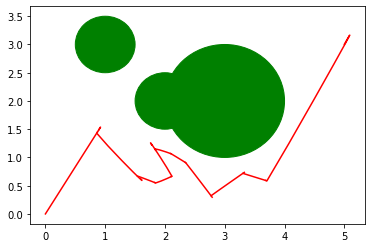

In [114]:
fig, ax = plt.subplots()

for i in range(0, len(waypoints)-1):
    traj, _ = rollout(waypoints[i], waypoints[i+1], N, dt, dist_tol=dist_tol)
    valid_samples = filter_samples(traj, obstacles, 2, self_r, N)
    stepsize = max(1, int(len(traj) / num_steps))
    valid_length = len(valid_samples)
    valid_traj = traj[:valid_length * stepsize]
    ax.plot(valid_traj[:, 0], valid_traj[:, 1], "r")
    
for obs in obstacles:
    circle = plt.Circle(obs.pos, obs.r, color='g')
    ax.add_patch(circle)
plt.show()

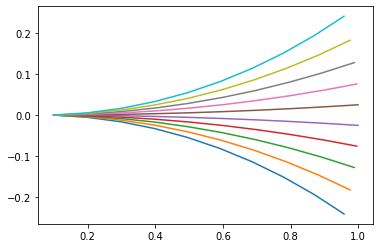

In [173]:
def rollout_const_vel(state, action, dt, T):
    """Note: state at timestep 0 is NOT  original state, but next state, so original state is not part of rollout. This means
    every trajectory contains N successor states not including original state.
    Args:
        state ([type]): [description]
        v ([type]): [description]
        steer ([type]): [description]
        dt ([type]): [description]
        T ([type]): [description]
    Returns:
        [type]: [description]
    """
    v, steer = action
    N = int(T / float(dt))  # number of steps
    traj = np.zeros(shape=(N, 3))
#     traj[:, 3] = v  # constant velocity throughout
#     state = np.array(state[:3])
    t = 0
    for i in range(N):
        theta = state[2]

        # state derivatives
        thetadot = v * math.tan(steer)
        xdot = v * math.cos(theta)
        ydot = v * math.sin(theta)
        state_dot = np.array([xdot, ydot, thetadot])

        # update state and store
        state = state + state_dot * dt
        t += dt
        traj[i] = state

    return traj

vmax = 1
steer_angles = np.linspace(-0.5, 0.5, 10)
init_state = np.zeros(3)
dt = 0.1
T = 1
endpoints = [init_state[:2]]
for steer in steer_angles:
    action = (vmax, steer)
    traj = rollout_const_vel(init_state, action, dt, T)
    endpoints.append(traj[-1, :2])
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.show()

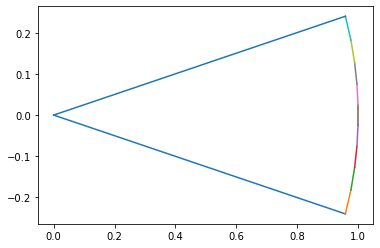

In [171]:
for i in range(len(endpoints)-1):
    xline = [endpoints[i][0], endpoints[i+1][0]]
    yline = [endpoints[i][1], endpoints[i+1][1]]
    plt.plot(xline, yline)

# last endpoint to start
xline = [endpoints[-1][0], endpoints[0][0]]
yline = [endpoints[-1][1], endpoints[0][1]]
plt.plot(xline, yline)
plt.show()